<a href="https://colab.research.google.com/github/giuseppesalvi/MLinA-Selective-Classification/blob/main/MLinA_Selective_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import glob
import pickle
import numpy as np
import tensorflow as tf
from scipy import io as spio
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split

ROOTDIR_DATA = "/content/drive/MyDrive/Datasets/Teaching_dataset/"
ROOTDIR_SRC = "/content/drive/MyDrive/Datasets/Teaching_dataset/teaching-MLinAPP/src"

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
plt.style.use(os.path.join(ROOTDIR_SRC, "mystyle.mplstyle"))
import sys
sys.path.append(ROOTDIR_SRC)

# Thresholding the uncertain

## Load original and corrupted data

### Cifar10
Do not shuffle the dataset

In [5]:
(cifar10_train, cifar10_test), cifar10_info = tfds.load(
    'cifar10',
    split=["train", "test"],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete40WQH4/cifar10-train.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cifar10/3.0.2.incomplete40WQH4/cifar10-test.tfrecord


  0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /root/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


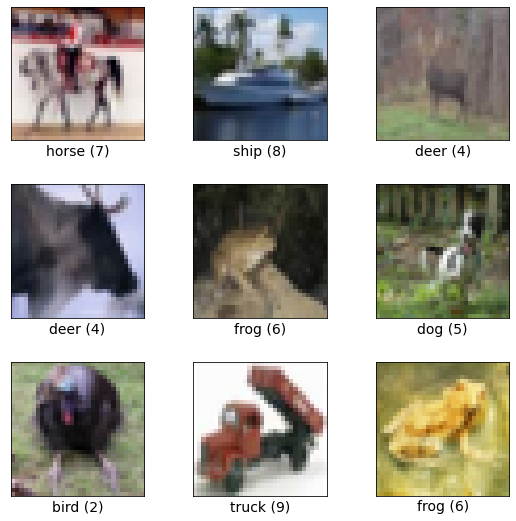

In [6]:
def process_data(image, label):
    return tf.cast(image, tf.float32)/255., tf.one_hot(label, 10, name='label', axis=-1)
    
fig = tfds.show_examples(cifar10_train, cifar10_info)

cifar10_train = cifar10_train.map(process_data, num_parallel_calls=tf.data.AUTOTUNE)
cifar10_train = cifar10_train.cache()
cifar10_train = cifar10_train.batch(128)
cifar10_train = cifar10_train.prefetch(tf.data.AUTOTUNE)

cifar10_test = cifar10_test.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
cifar10_test = cifar10_test.cache()
y_true_cifar10_test = np.array([y.numpy() for x, y in cifar10_test])
cifar10_test = cifar10_test.batch(128)
cifar10_test = cifar10_test.prefetch(tf.data.AUTOTUNE)

### Corrupted dataset
Do not shuffle the dataset, make a tf dataset

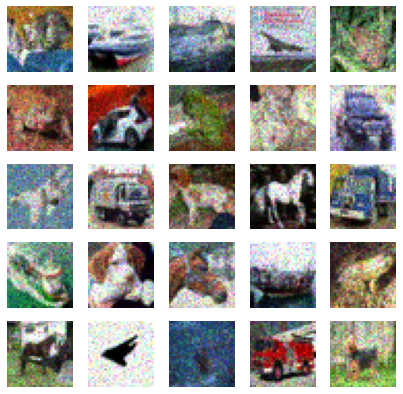

In [7]:
corruption_level = 4
corruption = np.load(os.path.join(ROOTDIR_DATA, "CIFAR-10-C/shot_noise.npy"))
corruption = corruption[corruption_level*10000:(corruption_level+1)*10000]
label_corruption = np.load(os.path.join(ROOTDIR_DATA, "CIFAR-10-C/labels.npy")
)[corruption_level*10000: (corruption_level+1)*10000]

corruption_ds = tf.data.Dataset.from_tensor_slices((corruption, label_corruption))
fig, ax = plt.subplots(5, 5, figsize=(7, 7))
ax = ax.ravel()
j = 0
for x, y in corruption_ds.take(25):
    ax[j].imshow(x.numpy())
    ax[j].axis('off')
    j += 1
corruption_ds = corruption_ds.map(
    process_data, num_parallel_calls=tf.data.AUTOTUNE)
corruption_ds = corruption_ds.cache()
corruption_ds = corruption_ds.batch(128)
corruption_ds = corruption_ds.prefetch(tf.data.AUTOTUNE)

## Load pre-trained CNN

In [8]:
from resnet import ResNet
input_shape = (32, 32, 3)
num_classes = 10
draws = 5 #  with 'all' as TTA policy this means draws*4 total samples
model = ResNet((input_shape[0], input_shape[1]), 
               num_classes=num_classes, 
               augment=True)
model.compile(metrics=["accuracy"])
model.built = True
model.load_weights(os.path.join(ROOTDIR_DATA, "models_cifar/checkpoint_cifar10_lr_red"))

## Evaluate on test folds

In [9]:
results_cifar = model.evaluate(cifar10_test, verbose=0)
print("Accuracy on cifar10 test set: {:.2f}".format(results_cifar[1]))

Accuracy on cifar10 test set: 0.83


In [10]:
results_corruption = model.evaluate(corruption_ds, verbose=0)
print("Accuracy on noisy cifar10 test set: {:.2f}".format(results_corruption[1]))

Accuracy on noisy cifar10 test set: 0.30


TTA Wrapper

In [29]:
class TTAWrapper:
    def __init__(self, keras_model, input_shape=(32, 32, 3)):
        super(TTAWrapper, self).__init__()
        self.model = keras_model
        self._input_shape = input_shape
        self._uncertainty_metrics = dict()
        self._uncertainty_metrics['entropy'] = self._entropy
        self._uncertainty_metrics['variance'] = self._variance
        self._uncertainty_metrics['max_softmax_response'] = self._max_softmax_response

    def uncertainty_metrics(self, multiple_preds):
        return {metric: self._compute_uncertainty(metric, multiple_preds) for metric in self._uncertainty_metrics.keys()}
    
    def _normalize(self, values):
        # normalize the output throught 0 and 1
        return (values - values.min()) / (values.max() - values.min())

    def _compute_uncertainty(self, metric, multiple_preds):
        try:
            print("Done {}".format(metric))
            return self._normalize(self._uncertainty_metrics[metric](multiple_preds))
        except KeyError:
            print("{} not implemented.".format(metric))

    def predict_many_times(self, inputs, draws=2):
        # make n=draws predictions, and return the result in a np array
        return np.array([self.predict(inputs) for _ in range(draws)])

    def _average_prediction(self, multiple_preds):
        # to compute the average prediction, calculate the mean on the first 
        # columnt (axis=0), so on the same sample over different predictions 
        if len(multiple_preds.shape) > 2:
            return np.mean(np.array(multiple_preds), axis=0)
        else:
          return multiple_preds

    def _variance(self, multiple_preds):
        # note: if the output of the network is sure, the variance will be higher
        # for example the softmax for class a is always high and for class c and
        # b is always low
        avg_preds = self._average_prediction(multiple_preds)
        return np.var(avg_preds, axis=1)

    def _max_softmax_response(self, multiple_preds):
        avg_preds = self._average_prediction(multiple_preds)
        return np.max(avg_preds, axis=1)

    def _entropy(self, multiple_preds):
        avg_preds = self._average_prediction(multiple_preds)
        eps = 1e-5
        return -1 * np.sum(avg_preds * np.log(avg_preds + eps), axis=1)

    def predict_many_times(self, ds, policy, draws=1):
        pred_augmented = list()

        # Different kinds of data augmentations
        # Random Crop
        policy_random_crop = [
            tf.keras.Sequential([
                tf.keras.layers.RandomCrop(15, 15),
                tf.keras.layers.Resizing(28, 28)])]

        # Flip
        policy_random_flip = [
            tf.keras.Sequential([
                tf.keras.layers.RandomFlip("horizontal")])
        ]

        # Change Contrast
        policy_random_contrast = [
            tf.keras.Sequential([
                tf.keras.layers.RandomContrast(0.3, 0.3)])
        ]

        # Zoom
        policy_random_zoom = [
            tf.keras.Sequential([
                tf.keras.layers.RandomZoom(0.3)])
        ]

        policy_identity = [tf.keras.Sequential([
            tf.keras.layers.Layer()])]

        policies = dict()
        policies['identity'] = policy_identity
        policies['random_crop'] = policy_random_crop
        policies['random_contrast'] = policy_random_contrast
        policies['random_zoom'] = policy_random_zoom
        policies['random_flip'] = policy_random_flip
        policies['all'] = sum([policy_random_crop, policy_random_contrast, policy_random_zoom, policy_random_flip], [])

        policies['random_crop'] = sum([policies['random_crop'] for _ in range(draws)], [])
        policies['random_contrast'] = sum([policies['random_contrast'] for _ in range(draws)], [])
        policies['random_zoom'] = sum([policies['random_zoom'] for _ in range(draws)], [])
        policies['random_flip'] = sum([policies['random_flip'] for _ in range(draws)], [])
        policies['all'] = sum([policies['all'] for _ in range(draws)], [])

        for p in policies[policy]:
            ds_augmented = ds.map(lambda x, y: (p(x, training=True), y))
            pred_augmented.append(self.model.predict(ds_augmented))

        return pred_augmented


In [30]:
tta_model = TTAWrapper(model)

## Make predictions for cifar and corrupted datasets

In [31]:
cifar10_preds = model.predict(cifar10_test)
corruption_preds = model.predict(corruption_ds)
cifar10_many_preds = tta_model.predict_many_times(cifar10_test, "all", draws=draws)
corruption_many_preds = tta_model.predict_many_times(corruption_ds, "all", draws=draws)

## Plot uncertianties distributions

In [ ]:
[...]

Now we can put a threshold $\theta$ on the uncertainties distribution to identify, and eventually remove, those **not-confident** predictions.The following procedure will provide a method to automatically identify such threshold

# Risk-Coverage analysis

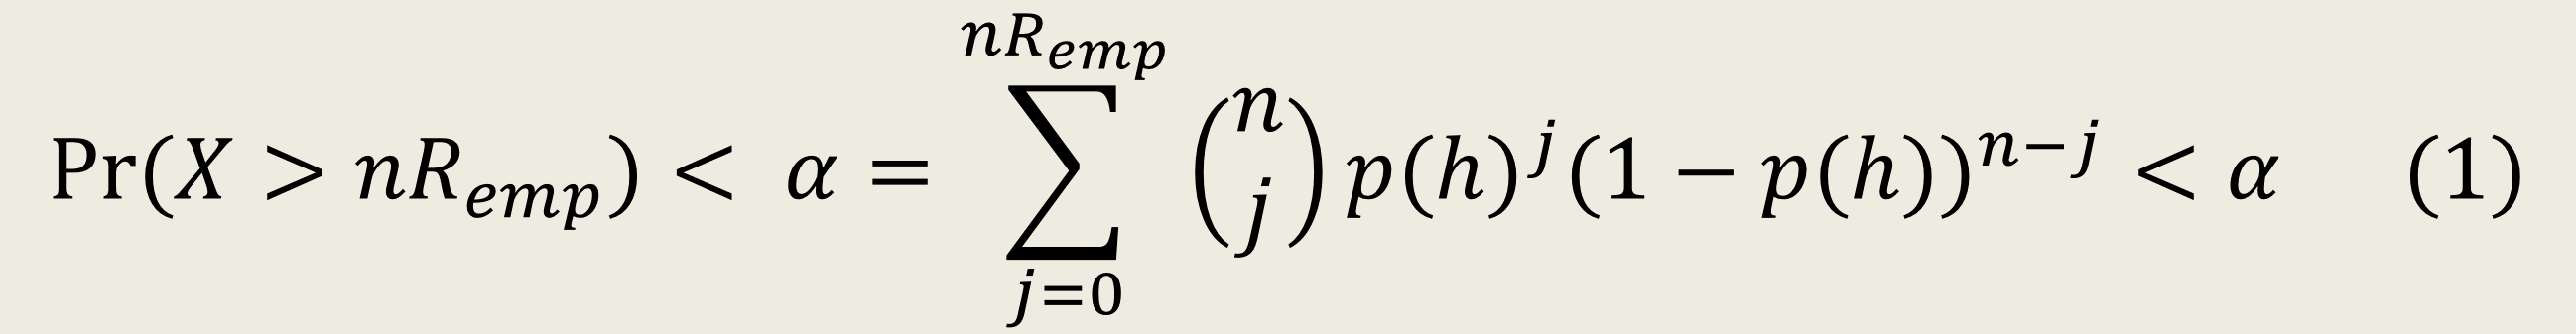

*   This means: **“We want the probability of observing more than $nR_{𝑒𝑚𝑝}$ errors in n trials less than 𝛼”**
*   The inequation (1) depends on **p**, the **true risk** on the data distribution $D$
*   Fixed the empirical risk, we evaluate which p ensures (1) by computing the cumulative density function of a binomial with parameters $p, n, nR_{emp}$


In [ ]:
import scipy.stats
def get_risk_bound(n, r_emp, alpha=0.01):
    [...]

Now we can vary the empirical risk thanks to a selection function $𝑔_𝜃 (𝑥)$, based on a confidence measure 𝜅


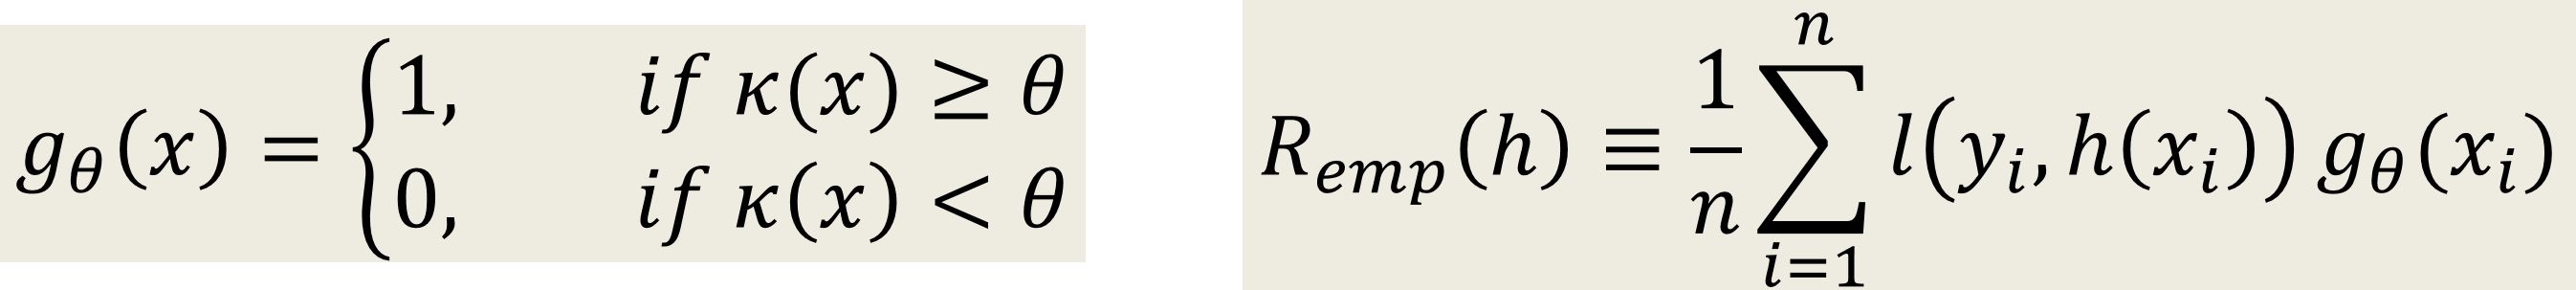

The empirical risk can be traded-off by coverage
*   Coverage is defined as the probability mass of the non-rejected region in $X$ (i.e., the observed number of non-rejected samples)
*   That is, among all the classifiers satisfying $Pr⁡(𝑋>𝑛𝑅_{𝑒𝑚𝑝})< 𝛼$ the best one is that which maximize the coverage
*   The performance profile of the classifier can be specified by risk-coverage curves

Notably, **fixed an acceptable true risk $𝑅^∗$, $\alpha$, and 𝜅 we can obtain the threshold 𝜃 and the corresponding coverage**

**Note that the tailoring of the threshold $\theta$ must be done on the training dataset**

## Function to get $\theta$, i.e., the threshold on the confidence meaure.

In [ ]:
def get_theta(y_pred, y_true, r, alpha, confidence_values):
    [...]

Since **that the setting of the threshold $\theta$ must be done on the training dataset**, we predict the **train fold of the cifar10**

Let's extract 10000 random images from the cifar10

In [ ]:
cifar10_train = cifar10_train.unbatch()
cifar10_train = cifar10_train.shuffle(buffer_size=50000, reshuffle_each_iteration=False)
cifar10_train = cifar10_train.take(10000)
y_true_cifar10_train = np.array([y.numpy() for x, y in cifar10_train])
cifar10_train = cifar10_train.batch(128)
cifar10_preds = model.predict(cifar10_train)
cifar10_many_preds = tta_model.predict_many_times(cifar10_train, "all", draws=draws)

## Explore all corruptions for all corruption levels with a mixed dataset 

In [ ]:
[...]

### Fix corruption level

In [ ]:
[...]

### Fix corruption type

In [ ]:
[...]

### Now compute coverage varying the risk for the gaussian_noise corruption type with corruption level 3

In [ ]:
[...]

### Lastly, let's evaluate on the test partiton for the above given corruption type, level and risk=0.2. Also consider variance as confidence metric

Plot a confusion matrix of the results with & without those samples identified as not confident

We get theta from the above computation on the traing set

In [ ]:
[...]

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import cm as plt_cmap
def seaborn_cm(cm, ax, tick_labels, fontsize=14):

    group_counts = ["{:0.0f}".format(value) for value in cm.flatten()]
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.nan_to_num(cm)
    group_percentages = ["{:0.0f}".format(value*100) for value in cm.flatten()]
    cm_labels = [f"{c}\n{p}%" for c, p in zip(group_counts, group_percentages)]
    cm_labels = np.asarray(cm_labels).reshape(len(tick_labels), len(tick_labels))
    sns.heatmap(cm,
                ax=ax,
                annot=cm_labels,
                fmt='',
                cbar=False,
                cmap=plt_cmap.Greys,
                linewidths=1, linecolor='black',
                annot_kws={"fontsize": fontsize},
                xticklabels=tick_labels,
                yticklabels=tick_labels)
    ax.set_yticklabels(ax.get_yticklabels(), size=fontsize, rotation=45)
    ax.set_xticklabels(ax.get_xticklabels(), size=fontsize, rotation=45)

In [ ]:
[...]

# Out-of-distribution
Load the data from the following filepath and make a tf dataset

## TTA

In [ ]:
filepath = os.path.join(ROOTDIR_DATA, "ood.npy")
ood = np.load(filepath)
label_ood = np.zeros(len(ood))

In [ ]:
ood_ds = [...]

Compute unceertainty metrics for TTA 

## MC dropout

In [ ]:
input_shape = (32, 32, 3)
num_classes = 10
draws = 20 #  Equivalent with 'all' as TTA policy (this means draws*4 total samples, with draws set as 5)

MC Wrapper

In [ ]:
[...]

In [ ]:
model = ResNet((input_shape[0], input_shape[1]), 
               num_classes=num_classes,
               mc_dropout=True,
               augment=True)
model.compile(metrics=["accuracy"])
model.built = True
model.load_weights(os.path.join(ROOTDIR_DATA, "models_cifar_mc-drop/checkpoint_cifar10_lr_red"))
mc_model = MCWrapper(model)

Test the model on cifar10 original

In [ ]:
[...]

Compute uncertainty metrics for MC dropout

Compute deterministic preds by loading again deterministic model and compute deterministic uncertainties

In [ ]:
input_shape = (32, 32, 3)
num_classes = 10
model = ResNet((input_shape[0], input_shape[1]), 
               num_classes=num_classes, 
               augment=True)
model.compile(metrics=["accuracy"])
model.built = True
model.load_weights(os.path.join(ROOTDIR_DATA, "models_cifar/checkpoint_cifar10_lr_red"))

In [ ]:
deterministic_preds_ood = model.predict(ood_ds)

Plot histograms comparing the different metrics (MC, TTA, deterministic) on the OOD